# Power mask

This example demonstrates how to derate or boost turbines by using a turbine model called `PowerMask`. We need the following imports:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import foxes
import foxes.variables as FV
import foxes.constants as FC

/home/jonas/gits/wakes/foxes/foxes/core/engine.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


We start by creating a simple states table, this time via a `pandas.DataFrame` object:

In [2]:
sdata = pd.DataFrame(index=range(8))
sdata.index.name = FC.STATE
sdata[FV.WS] = [5.0, 8.0, 11.0, 14.0, 18.0, 20.0, 22.0, 25.0]
print(sdata)

states = foxes.input.states.StatesTable(
    data_source=sdata,
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    fixed_vars={FV.WD: 270.0, FV.TI: 0.05, FV.RHO: 1.225},
)

         WS
state      
0       5.0
1       8.0
2      11.0
3      14.0
4      18.0
5      20.0
6      22.0
7      25.0


Next, we create the power mask for these states. The idea is that for each state and turbine, we can set a maximal power value in a table. 

- If the calculated power value is above this value, the turbine is derated.
- If the maximal power exceeds the nominal power of the turbine type and the calculated value is at nominal power, then the turbine is boosted to the maximal power value.
- If the maximal power value in the power mask is `NaN`, then the turbine is neither derated nor boosted (normal operation)

Again we create a `DataFrame` that contains the power mask data:

In [3]:
pmask = pd.DataFrame(index=sdata.index, columns=[f"PMax_{i}" for i in range(5)])
pmask.loc[np.s_[:4], "PMax_4"] = 1000
pmask.loc[np.s_[4:], "PMax_4"] = 6000
pmask.loc[np.s_[2:], "PMax_2"] = 3000
pmask.loc[0, "PMax_0"] = 300.0
pmask.loc[3, "PMax_0"] = 1000.0
print(pmask)

       PMax_0 PMax_1 PMax_2 PMax_3 PMax_4
state                                    
0       300.0    NaN    NaN    NaN   1000
1         NaN    NaN    NaN    NaN   1000
2         NaN    NaN   3000    NaN   1000
3      1000.0    NaN   3000    NaN   1000
4         NaN    NaN   3000    NaN   6000
5         NaN    NaN   3000    NaN   6000
6         NaN    NaN   3000    NaN   6000
7         NaN    NaN   3000    NaN   6000


Using this data we can now create the model book. Notice how the variable `FV.MAX_P` is set to the above values via the turbine model `SetFarmVars`:

In [4]:
mbook = foxes.models.ModelBook()
mbook.turbine_models["set_Pmax"] = foxes.models.turbine_models.SetFarmVars()
mbook.turbine_models["set_Pmax"].add_var(FV.MAX_P, pmask)

We can now create a wind farm that consists of 5 turbines in a row. Some thoughts about the `turbine_models` argument:

- The actual `PowerMask` turbine model is pre-defined in the default `ModelBook` under the name `PMask`, so we can just add it to the turbine model list.
- It should appear after the turbine type model `NREL5`, since `PMask` corrects the results od the latter.
- Furthermore, `PMask` should be placed somewhere _after_ the above created turbine model `set_Pmax` in the list of turbine models, such that the values of the variable `FV.MAX_P` are present at the time when `PMask` is called.
- The models `NREL5` and `set_Pmax` have no influence on each other, so their order does not matter.

We choose the following pattern:

In [5]:
models = ["NREL5MW", "set_Pmax", "PMask"]

farm = foxes.WindFarm()
foxes.input.farm_layout.add_row(
    farm,
    xy_base=[0.0, 0.0],
    xy_step=[600.0, 0.0],
    n_turbines=5,
    turbine_models=models,
)

Turbine 0, T0: xy=(0.00, 0.00), NREL5MW, set_Pmax, PMask
Turbine 1, T1: xy=(600.00, 0.00), NREL5MW, set_Pmax, PMask
Turbine 2, T2: xy=(1200.00, 0.00), NREL5MW, set_Pmax, PMask
Turbine 3, T3: xy=(1800.00, 0.00), NREL5MW, set_Pmax, PMask
Turbine 4, T4: xy=(2400.00, 0.00), NREL5MW, set_Pmax, PMask


We can now setup our algorithm and run the calculation:

In [6]:
algo = foxes.algorithms.Downwind(
    farm,
    states,
    rotor_model="centre",
    wake_models=["Bastankhah2014_linear_k002"],
    mbook=mbook,
    verbosity=0,
)

In [7]:
# run calculation with power mask:
farm_results = algo.calc_farm()

fr = farm_results.to_dataframe()
print(fr[[FV.WD, FV.AMB_REWS, FV.REWS, FV.MAX_P, FV.AMB_P, FV.P]])

o = foxes.output.FarmResultsEval(farm_results)
P0 = o.calc_mean_farm_power(ambient=True)
P = o.calc_mean_farm_power()
print(f"\nFarm power: {P / 1000:.1f} MW, Efficiency = {P / P0 * 100:.2f} %")

# this output is needed later:
o1 = foxes.output.StateTurbineMap(farm_results)

DefaultEngine: Selecting engine 'single'
SingleChunkEngine: Calculating 8 states for 5 turbines
SingleChunkEngine: Starting calculation using a single worker.
SingleChunkEngine: Completed all 1 chunks

                  WD  AMB_REWS       REWS    MAXP   AMB_P            P
state turbine                                                         
0     0        270.0       5.0   5.000000   300.0   300.0   300.000000
      1        270.0       5.0   3.806173     NaN   403.9   151.106903
      2        270.0       5.0   2.997697     NaN   403.9     0.000000
      3        270.0       5.0   3.651819     NaN   403.9   129.929624
      4        270.0       5.0   2.840554  1000.0   403.9     0.000000
1     0        270.0       8.0   8.000000     NaN  1771.1  1771.100000
      1        270.0       8.0   5.110762     NaN  1771.1   440.861136
      2        270.0       8.0   4.348633     NaN  1771.1   256.560767
      3        270.0       8.0   4.093786     NaN  1771.1   198.914426
      4        27

For a visualization of the results, let's re-run the case without the power mask:

In [8]:
# reset, for run calculation without power mask:
for t in farm.turbines:
    t.models.remove("set_Pmax")
    t.models.remove("PMask")

In [9]:
farm_results = algo.calc_farm()
o0 = foxes.output.StateTurbineMap(farm_results)

DefaultEngine: Selecting engine 'single'
SingleChunkEngine: Calculating 8 states for 5 turbines
SingleChunkEngine: Starting calculation using a single worker.
SingleChunkEngine: Completed all 1 chunks



We are now in the position to create plots that compare the turbine power results, using the two output objects `o0` and `o1`:

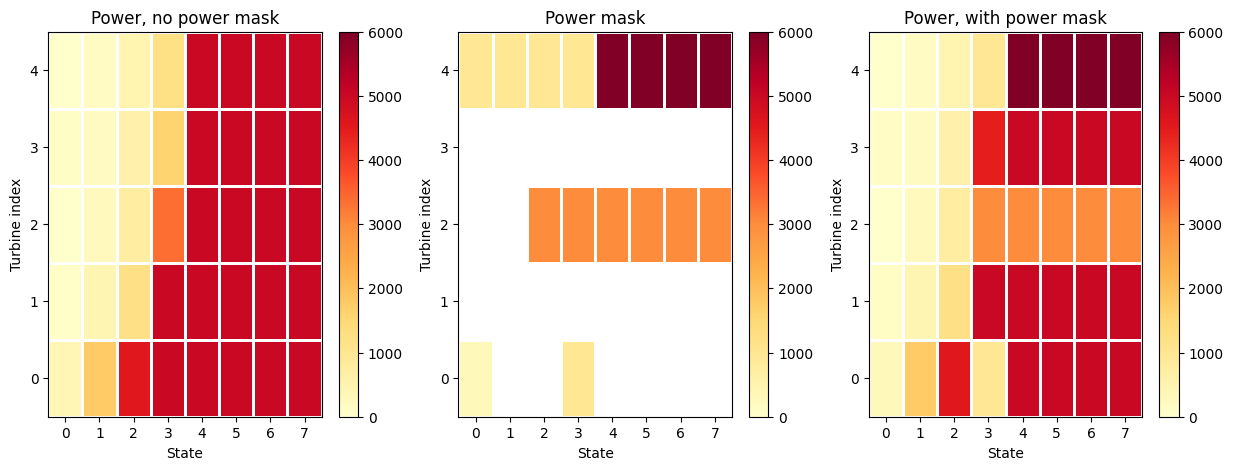

In [10]:
# show power:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
o0.plot_map(
    FV.P,
    ax=axs[0],
    edgecolor="white",
    title="Power, no power mask",
    cmap="YlOrRd",
    vmin=0,
    vmax=np.nanmax(pmask),
)
o1.plot_map(
    FV.MAX_P,
    ax=axs[1],
    edgecolor="white",
    cmap="YlOrRd",
    title="Power mask",
    vmin=0,
    vmax=np.nanmax(pmask),
)
o1.plot_map(
    FV.P,
    ax=axs[2],
    edgecolor="white",
    cmap="YlOrRd",
    title="Power, with power mask",
    vmin=0,
    vmax=np.nanmax(pmask),
)
plt.show()

Similarly, for the thrust coefficients:

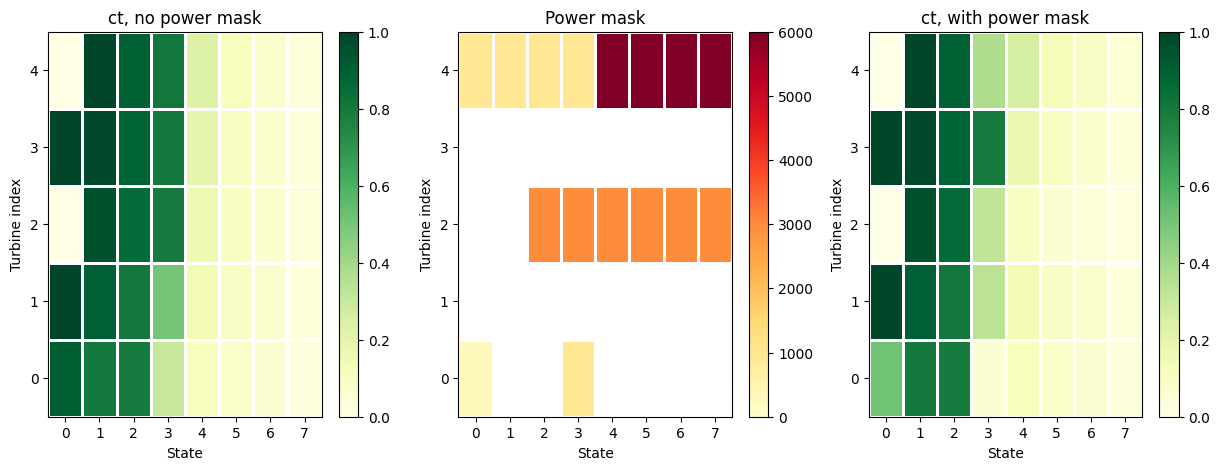

In [11]:
# show ct:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
o0.plot_map(
    FV.CT,
    ax=axs[0],
    edgecolor="white",
    title="ct, no power mask",
    cmap="YlGn",
    vmin=0,
    vmax=1.0,
)
o1.plot_map(
    FV.MAX_P,
    ax=axs[1],
    edgecolor="white",
    cmap="YlOrRd",
    title="Power mask",
    vmin=0,
    vmax=np.nanmax(pmask),
)
o1.plot_map(
    FV.CT,
    ax=axs[2],
    edgecolor="white",
    cmap="YlGn",
    title="ct, with power mask",
    vmin=0,
    vmax=1.0,
)
plt.show()

The above visualizations demonstrate that the power mask has effects on both the produced power and ct. Hence, also wakes are affected by derating and boosts.

We can also visualize the effect of the `PowerMask` model on power and thrust curve, here for the case of derating from 5 MW to 3 MW:

DefaultEngine: Selecting engine 'single'
SingleChunkEngine: Calculating 301 states for 1 turbines
SingleChunkEngine: Starting calculation using a single worker.
SingleChunkEngine: Completed all 1 chunks

DefaultEngine: Selecting engine 'single'
SingleChunkEngine: Calculating 301 states for 1 turbines
SingleChunkEngine: Starting calculation using a single worker.
SingleChunkEngine: Completed all 1 chunks



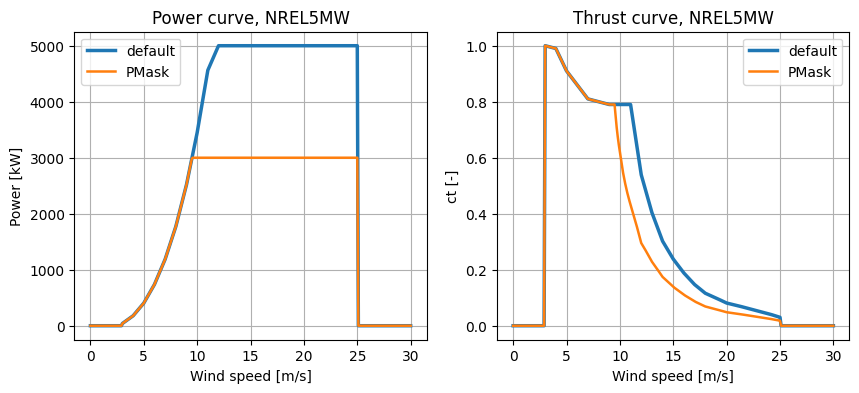

In [12]:
o = foxes.output.TurbineTypeCurves(mbook)
plot_data = o.calc_plot_data("NREL5MW", [FV.P, FV.CT], P_max=3000.0)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
o.plot_curves(plot_data, axs=axs)
plt.show()